# Visualizing 3D stereoscopic images

- https://docs.sunpy.org/en/stable/generated/gallery/showcase/stereoscopic_3d.html

How to make an anaglyph 3D image from a stereoscopic observation

We use a stereoscopic observation from July 2023, when the STEREO-A spacecraft
and the SDO spacecraft were close in heliographic longitude.  See the
[Wikipedia page on anaglyph 3D](https://en.wikipedia.org/wiki/Anaglyph_3D),
which typically requires red-cyan glasses to visualize.

In [ ]:
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
import sunpy.map
from sunpy.coordinates import SphericalScreen

Download co-temporal SDO/AIA image STEREO/EUVI images.  The EUVI map does
not explicitly define their reference radius of the Sun, so we set it to be
the same as for the AIA map to silence some informational messages.

In [ ]:
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_STEREOSCOPIC_IMAGE)
euvi_map = sunpy.map.Map(sunpy.data.sample.EUVI_STEREOSCOPIC_IMAGE)
euvi_map.meta['rsun_ref'] = aia_map.meta['rsun_ref']

Verify that the angular separation between the two vantage points is a few
degrees.  If the angular separation much larger, the 3D effect will be bad.

In [ ]:
euvi_map.observer_coordinate.separation(aia_map.observer_coordinate)

<Angle 3.71871066 deg>

Define a convenience function to reproject an input map to an observer in
same direction, but at a distance of 1 AU, and then reproject both maps. The
purpose is to make the Sun exactly the same size in pixels in both maps.

In [ ]:
def reproject_to_1au(in_map):
    header = sunpy.map.make_fitswcs_header(
        (1000, 1000),
        SkyCoord(
            0*u.arcsec, 0*u.arcsec,
            frame='helioprojective',
            obstime=in_map.date,
            observer=in_map.observer_coordinate.realize_frame(
                in_map.observer_coordinate.represent_as('unitspherical') * u.AU
            )
        ),
        scale=(2.2, 2.2)*u.arcsec/u.pixel
    )
    with SphericalScreen(in_map.observer_coordinate):
        return in_map.reproject_to(header)


euvi_map = reproject_to_1au(euvi_map)
aia_map = reproject_to_1au(aia_map)

Define linear scaling for the two images so that they look the same.  The
values here are empirical.

In [ ]:
euvi_norm = Normalize(vmin=750, vmax=1e4, clip=True)
aia_norm = Normalize(vmin=0, vmax=2.1e3, clip=True)

Plot the two maps side by side.  Those who are able to see 3D images by
defocusing their eyes can see the 3D effect without the later anaglyph
image.

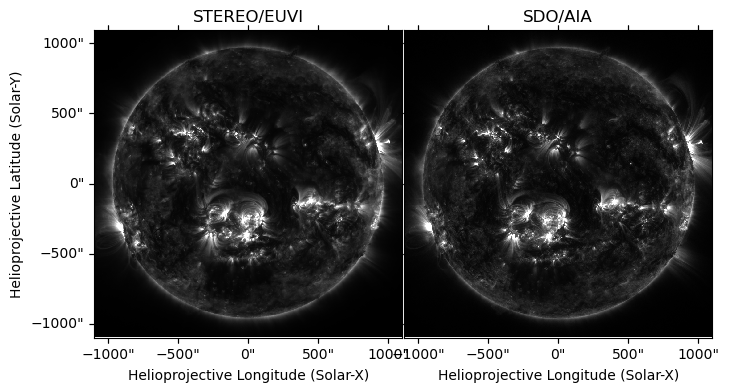

In [ ]:
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0)

ax1 = fig.add_subplot(121, projection=euvi_map)
euvi_map.plot(axes=ax1, cmap='gray', norm=euvi_norm)
ax1.grid(False)
ax1.set_title('STEREO/EUVI')

ax2 = fig.add_subplot(122, projection=aia_map)
aia_map.plot(axes=ax2, cmap='gray', norm=aia_norm)
ax2.coords[1].set_ticks_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
ax2.grid(False)
ax2.set_title('SDO/AIA')

plt.show()

We will make a color anaglyph 3D image by creating two colormaps based on an
initial colormap (here, ``'sdoaia171'``).  The left-eye colormap is just the
red channel, and the right-eye colormap is just the green and blue channels.
Thus, we zero out the appropriate channels in the two colormaps.

In [ ]:
cmap_left = copy.deepcopy(plt.get_cmap('sdoaia171'))
cmap_right = copy.deepcopy(cmap_left)

cmap_left._segmentdata['blue'] = [(0, 0, 0), (1, 0, 0)]
cmap_left._segmentdata['green'] = [(0, 0, 0), (1, 0, 0)]
cmap_right._segmentdata['red'] = [(0, 0, 0), (1, 0, 0)]

Finally, we build the anaglyph 3D image.  To easily plot in RGB color
channels, we will be passing a NxMx3 array to matplotlib's ``imshow``.  That
array needs to be manually normalized (to be between 0 and 1) and colorized
(mapped into the 3 color channels).  The colorizing actually adds a fourth
layer for the alpha layer, so we discard that layer.

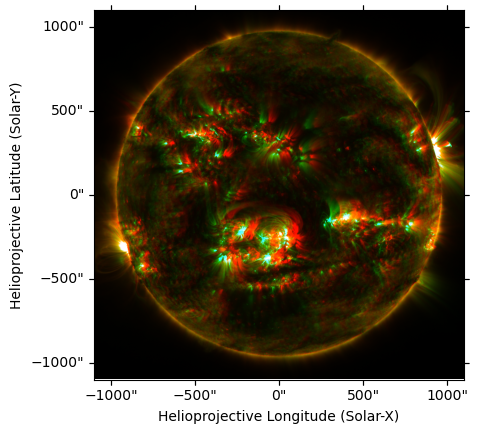

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)

euvi_data = euvi_norm(euvi_map.data)
aia_data = aia_norm(aia_map.data)
ax.imshow((cmap_left(euvi_data) + cmap_right(aia_data))[:, :, 0:3], origin='lower')

ax.set_xlabel('Helioprojective Longitude (Solar-X)')
ax.set_ylabel('Helioprojective Latitude (Solar-Y)')

plt.show()